In [1]:
import warnings
warnings.filterwarnings('ignore') # 実行に影響のない　warninig　を非表示にします. 非推奨.

# Chapter 6: Pytorchによる線形回帰
機械学習用のライブラリとして有名な**Pytorch**を利用して線形回帰を行ってみる
## 6-1. ライブラリの準備
（結構古めのバージョンでの実装になるので最新版だと動かないかも ？ 2021/9/21時点での最新ver=1.9）
```
conda install pytorch==1.6.0 torchvision==0.7.0 cpuonly -c pytorch
```


In [2]:
import torch
print(torch.__version__)

1.6.0


## 6-2. データセットをダウンロード&データの準備（Chapter 5とほぼ同じ）

In [3]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
! mv winequality-red.csv data/winequality-red.csv

--2021-09-30 14:17:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
archive.ics.uci.edu (archive.ics.uci.edu) をDNSに問いあわせています... 128.195.10.252
archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 84199 (82K) [application/x-httpd-php]
`winequality-red.csv' に保存中

100%[======================================>] 84,199       365KB/s 時間 0.2s     

2021-09-30 14:17:58 (365 KB/s) - `winequality-red.csv' へ保存完了 [84199/84199]



In [4]:
import pandas as pd
wine = pd.read_csv("./data/winequality-red.csv", sep=";") # sepは区切り文字の指定
display(wine.head(5))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
import numpy as np
np.random.seed(0) # random　の挙動を固定

X = wine[["density"]].values
T = wine["alcohol"].values
X = X - X.mean()
T = T - T.mean()

#X, Tそれぞれが最小値0, 最大値1になるように標準化
#追加の前処理部分
X = (X - X.min()) / (X.max() - X.min())
T = (T - T.min()) / (T.max() - T.min())

p = np.random.permutation(len(X))
X = X[p]
T = T[p]

X_train = X[:1000, :]
T_train = T[:1000]
X_test = X[1000:, :]
T_test = T[1000:]

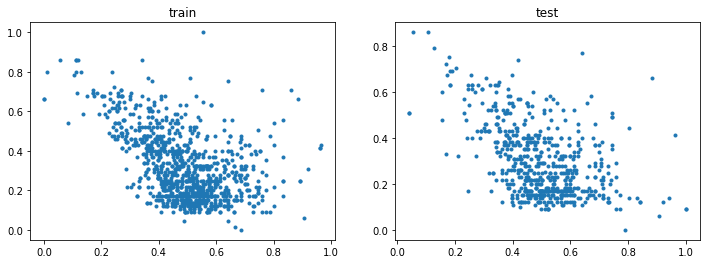

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

axes[0].scatter(X_train, T_train, marker=".")
axes[0].set_title("train")
axes[1].scatter(X_test, T_test, marker=".")
axes[1].set_title("test")
fig.show()

## 6-3 Pytorchでの学習構築
Pytorchは（厳密にはもちろん違うが）**モデル構造**と**データ**と**Loss**と**最適化手法**をそれぞれ与えるだけであとは勝手に回帰，ないしは分類などを行うことができる**学習済みモデル**を出力してくれる便利なライブラリ<br>
以下のコードの各行が何をしているのかを読み解いていく形で読むことをお勧めする

In [7]:
#モデル構造
class MyLinearRegression(torch.nn.Module):
    
    #初期化
    def __init__(self, n_input, n_output):#入力の次元と出力の次元を与える
        super().__init__()
        self.l1 = torch.nn.Linear(n_input, n_output, bias = True)
        """
        torch.nn.Linear
            (第一引数の入力次元数*第二引数に出力次元数の大きさの行列を定義することができる
            特に指定をしない限り学習過程で内部のパラメータは変化していく（初期値はランダム）
        """
        
    #sklearnで言うところの predict関数に相当
    def forward(self, x):
        h1 = self.l1(x)
        """
        self.l1(x)
            __init__で作った行列を使って入力xを予測値に変換する
        """
        return h1

loss関数には**二乗和誤差関数**，　最適化手法には**SGD**を用いた<br>
それぞれどのような手法なのか，他にどのような手法が（デフォルトで）適応できるのかについては公式を参照するのが早い<br>
loss関数: https://pytorch.org/docs/stable/nn.html#loss-functions <br>
最適化手法: https://pytorch.org/docs/stable/optim.html <br>
<br>
（基本的に**解析的に解けない問題**に対して用いるライブラリなので最適化手法には勾配法を用いる）<br>
解析的に求めれる　　➡︎　sklearn<br>
解析的に求めれない　➡︎　pytorch (keras・tensorflow)<br>
ベイズでモデル構築　➡︎　GPy PyMC3 Pystan etc...<br>
<br>
など目的に応じたライブラリを使用すると良い

In [8]:
#モデルの作成
model = MyLinearRegression(1, 1)

#loss関数の設定
criterion = torch.nn.MSELoss()
#criterion = torch.nn.L1Loss()

#最適化手法の設定
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        if train:
            self.X = torch.FloatTensor(X_train)
            self.t = torch.FloatTensor(T_train).view(-1, 1)
        else:
            self.X = torch.FloatTensor(X_test)
            self.t = torch.FloatTensor(T_test).view(-1, 1)
        self.data_length = len(self.t)

    def __getitem__(self, index):
        return self.X[index], self.t[index]

    def __len__(self):
        return self.data_length

In [10]:
from torch.utils.data import DataLoader

batch_size = 1000
trainset = Dataset(train=True)
testset  = Dataset(train=False)
trainloader = DataLoader(dataset = trainset, batch_size = batch_size, shuffle = True)
testloader  = DataLoader(dataset = testset,  batch_size = batch_size, shuffle = True)

In [11]:
epochs = 1000
loss_list = []
param_list = []
num_batchs = len(trainloader) // batch_size + 1
for epoch in range(epochs):
    loss_sum = 0
    for X, t in trainloader:
        t_pred = model(X)
        loss = criterion(t_pred, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum += loss.detach()
    loss_sum /= num_batchs
    loss_list.append(loss_sum)
    st_dict = model.state_dict()
    param_list.append([st_dict['l1.weight'].detach().numpy()[0, 0], st_dict['l1.bias'].detach().numpy()[0], epoch])
    print(f'\repoch: {epoch+1}/{epochs}, train loss: {loss_sum}', end='')
param_list = np.array(param_list)

epoch: 1000/1000, train loss: 0.021366847679018974

Text(0, 0.5, 'Loss')

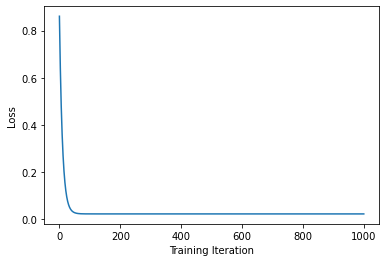

In [12]:
plt.plot(loss_list)
plt.xlabel('Training Iteration') 
plt.ylabel('Loss') 

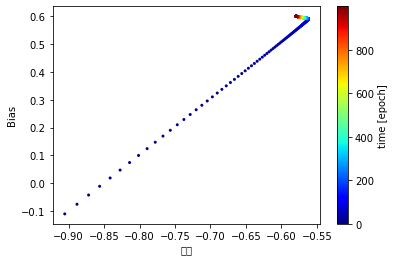

In [13]:
#学習におけるパラメータの推移を可視化
from matplotlib import cm
plt.scatter(param_list[:, 0], param_list[:, 1],
            c=param_list[:, 2],
            cmap=cm.jet,#カラーマップの種類
            marker='.',lw=0)
plt.xlabel('係数') 
plt.ylabel('Bias') 
ax=plt.colorbar()#カラーマップの凡例
ax.set_label('time [epoch]')#カラーバーのラベルネーム
plt.show()

In [14]:
model.eval()
num_batchs = len(testloader) // batch_size + 1
with torch.no_grad():
    loss_sum = 0
    for X, t in testloader:
        t_pred = model(X)
        loss_sum += criterion(t_pred, t).detach()
        
    loss_sum /= num_batchs
    
print('test_loss: ', loss_sum.detach().numpy())

test_loss:  0.018449452


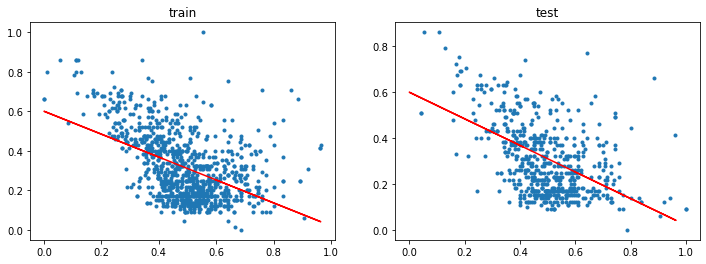

In [15]:
predict = model(torch.FloatTensor(X_train)).detach().numpy()

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

axes[0].scatter(X_train, T_train, marker=".")
axes[0].plot(X_train, predict, color="red")
axes[0].set_title("train")

axes[1].scatter(X_test, T_test, marker=".")
axes[1].plot(X_train, predict, color="red")
axes[1].set_title("test")
fig.show()

In [16]:
st_dict = model.state_dict()
print('係数: ', st_dict['l1.weight'].detach().numpy()[0, 0])
print('bias: ', st_dict['l1.bias'].detach().numpy()[0])

係数:  -0.5795411
bias:  0.6002073


# 課題
**上記のプログラムを読んだ上で条件を変えて回帰（または分類）を行いどのような変化があるのかを調査し，なぜそのような変化が起こったのかを考察せよ**<br>
（例）<br>
多項式回帰にしてみる, 標準化せずにやってみる, bias=Falseにしてみる<br>
epoch数, 　batch_size, loss関数, optimizer（の種類，またはパラメータ）を変更してみる<br>
chapter5で紹介した分類問題をpytorchで解いてみる<br>
など